# Use all the features to predict various objectives

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib
import string
from scipy.stats import norm
import scipy.stats as stats
import rpy2

import notebook.nbextensions
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import ticker
import matplotlib.dates as mdates

import numpy as np, pylab as pl
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

from scipy.stats import sem

from __future__ import division


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [5]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')


In [6]:
feature_names = pd.read_csv((os.path.join(repos_path, "data/processed/ALLFEATURES_meta_labelled.CSV")), index_col='feature_name')

In [7]:
features = pd.read_csv((os.path.join(repos_path, "data/processed/ALLFEATURES.CSV")), index_col='Unnamed: 0')

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, Office_Abbey to UnivLab_Tracy
Columns: 315 entries, BG_all_meanvs95_max to BG_weekend_minvsmax_std
dtypes: float64(315)
memory usage: 1.2+ MB


In [9]:
feature_names.head()

,feature_type,usetype_applicable,constype_applicable,operationtype_applicable
feature_name,,,,
BG_all_meanvs95_max,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_mean,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_min,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_std,dailyratios,usetype,constype,operationtype
BG_all_meanvsmax_max,dailyratios,usetype,constype,operationtype


In [10]:
def plot_confusion_matrix(cm, categories, title='Confusion matrix', cmap='Reds'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks,categories, rotation=90)
    plt.yticks(tick_marks,categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [11]:
meta.head()

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,sqft,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename
uid,,,,,,,,,,,,,,,,,,
PrimClass_Everett,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,105530.0,9804.053590,Primary/Secondary School,America/New_York,NaN,Everett,PrimClass,weather12.csv
UnivClass_Clifford,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,College Classroom,NaN,56969.0,5292.591007,College/University,America/New_York,1967,Clifford,UnivClass,weather2.csv
Office_Elizabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,294651.0,27373.961850,Commercial Real Estate,America/Los_Angeles,NaN,Elizabeth,Office,weather22.csv
Office_Ellie,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,496517.0,46127.918850,Bank/Financial Services,America/Los_Angeles,NaN,Ellie,Office,weather28.csv
PrimClass_Elisabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,233062.0,21652.158990,Primary/Secondary School,America/New_York,NaN,Elisabeth,PrimClass,weather23.csv


In [12]:
features = features.fillna(0)

In [13]:
def runmodel(features, meta, target_name, cmap, objective_name):
    sns.set_style("whitegrid")
    target = meta.sort_index()[target_name]
    target = target.dropna()
    features = features.T[target.index].T
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.6, random_state=2)
    model_rf = RandomForestClassifier(oob_score = True, max_features = 'auto', n_estimators = 100, min_samples_leaf = 2, 
                                          random_state = 2)
    model_rf.fit(features_train, target_train)
    #mean_model_accuracy = model_rf.score(features_test, target_test)
    mean_model_accuracy = model_rf.oob_score_
    print "Model accuracy: "+str(mean_model_accuracy)
    #accuracy[key] = mean_model_accuracy

    #Dummy Classifier model to get a baseline
    baseline_rf = DummyClassifier(strategy='stratified',random_state=0)
    baseline_rf.fit(features_train, target_train)
    #DummyClassifier(constant=None, random_state=1, strategy='most_frequent')
    baseline_model_accuracy = baseline_rf.score(features_test, target_test)
    print "Model accuracy: "+str(baseline_model_accuracy) 
    #accuracy["Baseline"] = baseline_model_accuracy

    #Create the classification report for the real model
    y_pred = model_rf.predict(features_test)
    y_true = np.array(target_test)
    categories = np.array(target.sort_values().unique())
    print classification_report(y_true, y_pred)

    #from: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    importances = model_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1])[:20]:
        print("%d. feature %s (%f)" % (f + 1, features.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,6))
    plt.title(objective_name+" Feature Importances")
    plt.barh(range(15), importances[indices][:15], color=cmap[0], align="center")
    plt.yticks(range(15), features.columns[indices][:15])#
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0.4)
    plt.savefig(os.path.join(repos_path,"reports/figures/classification/FeatureImportance_"+objective_name+".png"));
    plt.show()

    # Compute confusion matrix: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    sns.set(font_scale=1.4)
    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cm, categories, cmap=cmap)


    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cm_normalized, categories, title=objective_name+' Normalized Classification Error Matrix', cmap=cmap)
#     cbar.ax.set_ylabel('Accuracy of Classification', rotation=270)
    plt.savefig(os.path.join(repos_path,"reports/figures/classification/ConfusionMatrix_"+objective_name+".png"));
    plt.show()
    
    return mean_model_accuracy, baseline_model_accuracy#, target, indices, features

# Building Use Type

In [14]:
features_buildinguse = features[feature_names[feature_names.usetype_applicable == 'usetype'].index]

Model accuracy: 0.673267326733
Model accuracy: 0.222950819672
             precision    recall  f1-score   support

     Office       0.50      0.81      0.62        90
  PrimClass       0.94      0.74      0.83        65
  UnivClass       0.80      0.15      0.26        52
   UnivDorm       0.90      0.83      0.86        46
    UnivLab       0.59      0.63      0.61        52

avg / total       0.72      0.66      0.64       305

Feature ranking:
1. feature BG_stlweeklypattern_sun_mean (0.030267)
2. feature BG_stlreminder_jul_mean (0.019201)
3. feature BG_stlweeklypattern_fri_mean (0.017248)
4. feature BG_stlreminder_aug_mean (0.016041)
5. feature BG_loadshape_mape_interval (0.014963)
6. feature BG_eemeter_cvrmse (0.014723)
7. feature BG_breakouts_max_30_1_5 (0.013342)
8. feature BG_consumpstats_kwvarsummer (0.013318)
9. feature BG_weekdays_meanvs95_std (0.011920)
10. feature BG_hourlystats_maxHOD (0.011791)
11. feature BG_stlweeklypattern_wed_mean (0.011490)
12. feature BG_weekdays_

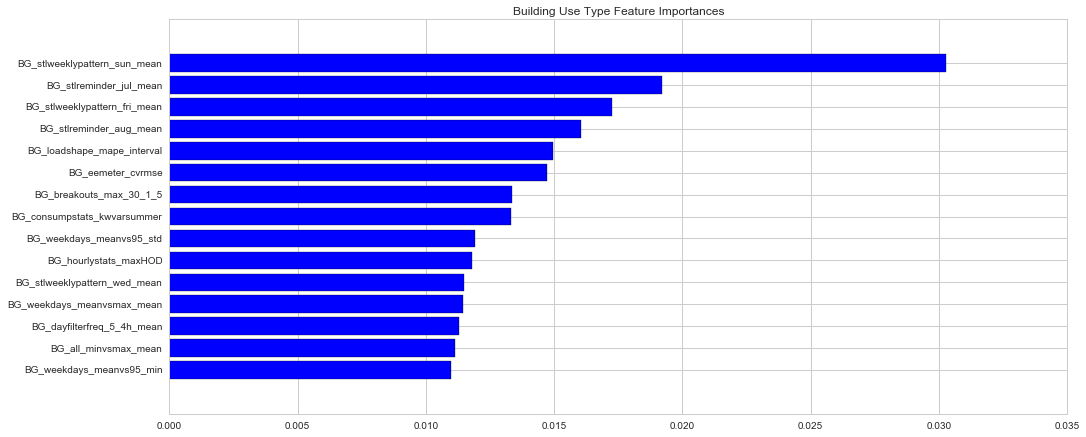

Confusion matrix, without normalization
[[73  0  2  1 14]
 [17 48  0  0  0]
 [32  3  8  2  7]
 [ 6  0  0 38  2]
 [18  0  0  1 33]]
Normalized confusion matrix
[[ 0.81  0.    0.02  0.01  0.16]
 [ 0.26  0.74  0.    0.    0.  ]
 [ 0.62  0.06  0.15  0.04  0.13]
 [ 0.13  0.    0.    0.83  0.04]
 [ 0.35  0.    0.    0.02  0.63]]


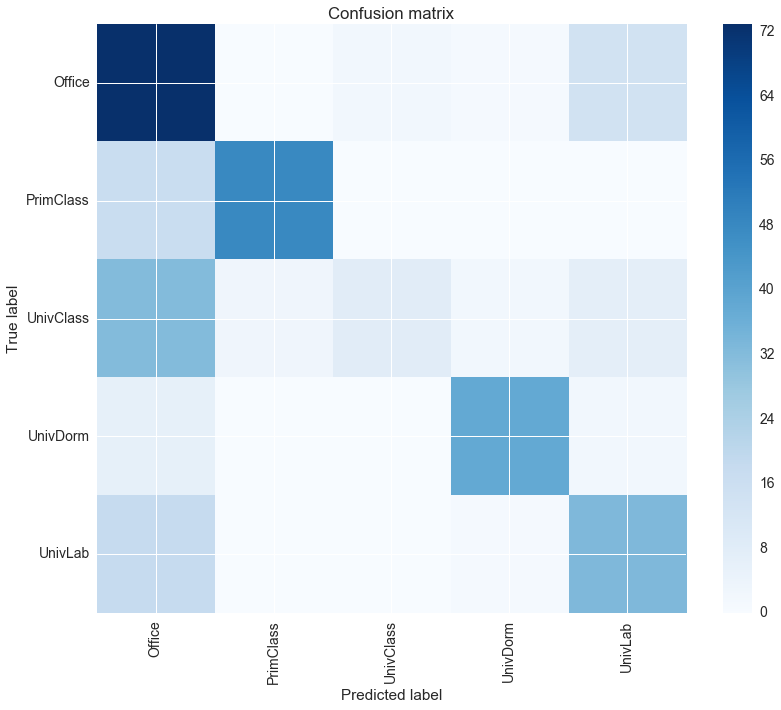

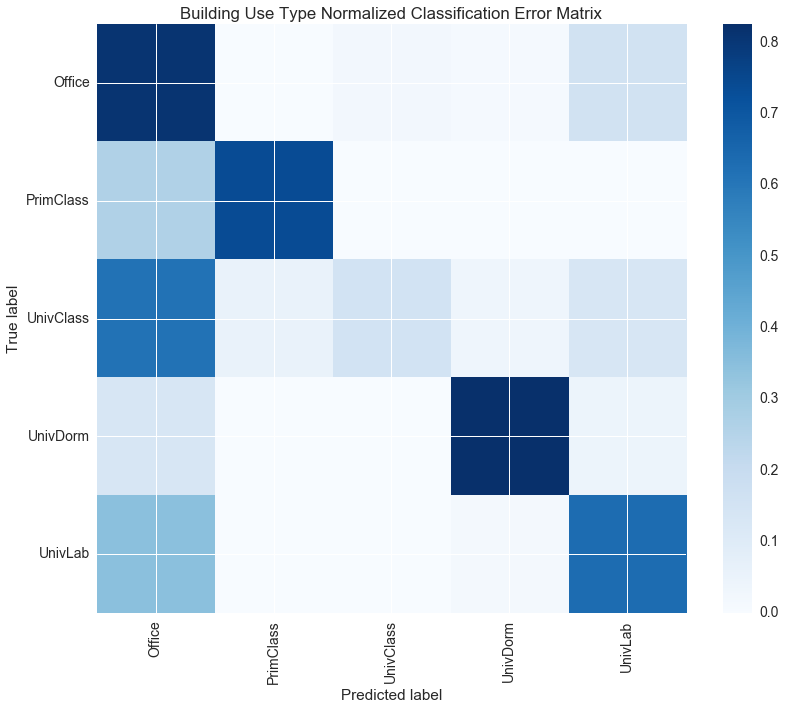

In [15]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(features_buildinguse, meta, "primaryspaceuse_abbrev", "Blues", "Building Use Type")

# Building Performance Class

In [176]:
meta['dailymeancons'] = features.BG_normalizedcons_mean

In [177]:
def categorize_2level(df, x):
    if x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.5):
        return "Below Average"
    else:
        return "Above Average"

def categorize_3level(df, x):
    if x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.333):
        return "Low"
    elif (x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.677)) & (x.dailymeancons > df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.333)):
        return "Intermediate"
    else:
        return "High"
    

In [178]:
meta["usagecategory"] = meta.apply(lambda x: categorize_3level(meta, x), axis=1)

In [179]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, PrimClass_Everett to UnivLab_Aoife
Data columns (total 21 columns):
dataend                   507 non-null datetime64[ns]
datastart                 507 non-null datetime64[ns]
energystarscore           26 non-null float64
heatingtype               124 non-null object
industry                  507 non-null object
mainheatingtype           122 non-null object
numberoffloors            124 non-null float64
occupants                 105 non-null float64
primaryspaceusage         507 non-null object
rating                    131 non-null object
sqft                      507 non-null float64
sqm                       507 non-null float64
subindustry               507 non-null object
timezone                  507 non-null object
yearbuilt                 313 non-null object
nickname                  507 non-null object
primaryspaceuse_abbrev    507 non-null object
newweatherfilename        507 non-null object
dailymeancons             

In [180]:
features_perfclass = features[feature_names[feature_names.constype_applicable == 'constype'].index]

In [181]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, Office_Abbey to UnivLab_Tracy
Columns: 315 entries, BG_all_meanvs95_max to BG_weekend_minvsmax_std
dtypes: float64(315)
memory usage: 1.2+ MB


Model accuracy: 0.623762376238
Model accuracy: 0.380327868852
             precision    recall  f1-score   support

       High       0.47      0.64      0.54        88
Intermediate       0.47      0.30      0.37       114
        Low       0.57      0.63      0.60       103

avg / total       0.50      0.51      0.49       305

Feature ranking:
1. feature BG_seasonal_Jan_range (0.027307)
2. feature BG_loadshape_rmse_interval_daytime (0.026286)
3. feature BG_seasonal_Aug_range (0.018145)
4. feature BG_loadshape_rmse_interval (0.017652)
5. feature BG_stlreminder_aug_mean (0.014022)
6. feature BG_stats_minhrkw (0.013790)
7. feature BG_all_minvsmax_min (0.013178)
8. feature BG_stlreminder_sep_mean (0.012448)
9. feature BG_all_meanvsmax_std (0.012348)
10. feature BG_weekdays_meanvs95_std (0.011069)
11. feature BG_stats_minhrdate (0.010994)
12. feature BG_weekdays_meanvsmax_mean (0.010318)
13. feature BG_all_meanvs95_std (0.010030)
14. feature BG_eemeter_cvrmse (0.009741)
15. feature BG_all

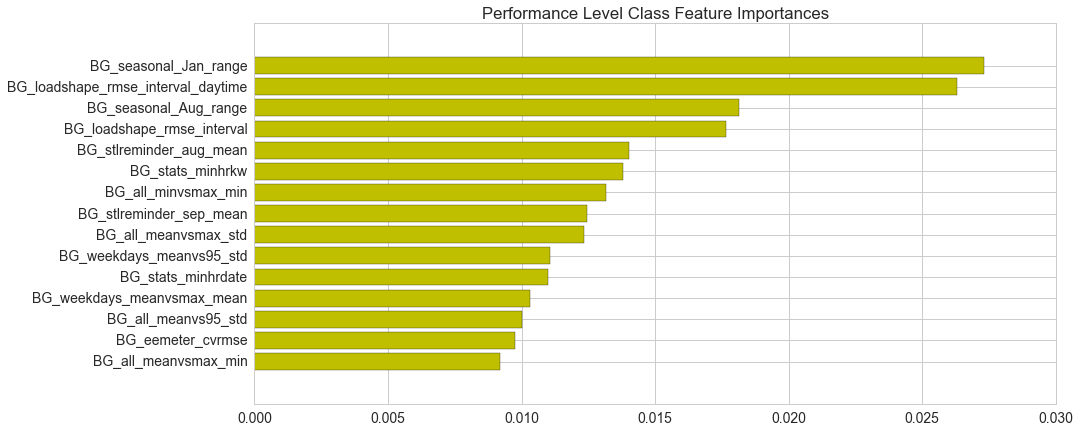

Confusion matrix, without normalization
[[56 18 14]
 [44 34 36]
 [18 20 65]]
Normalized confusion matrix
[[ 0.64  0.2   0.16]
 [ 0.39  0.3   0.32]
 [ 0.17  0.19  0.63]]


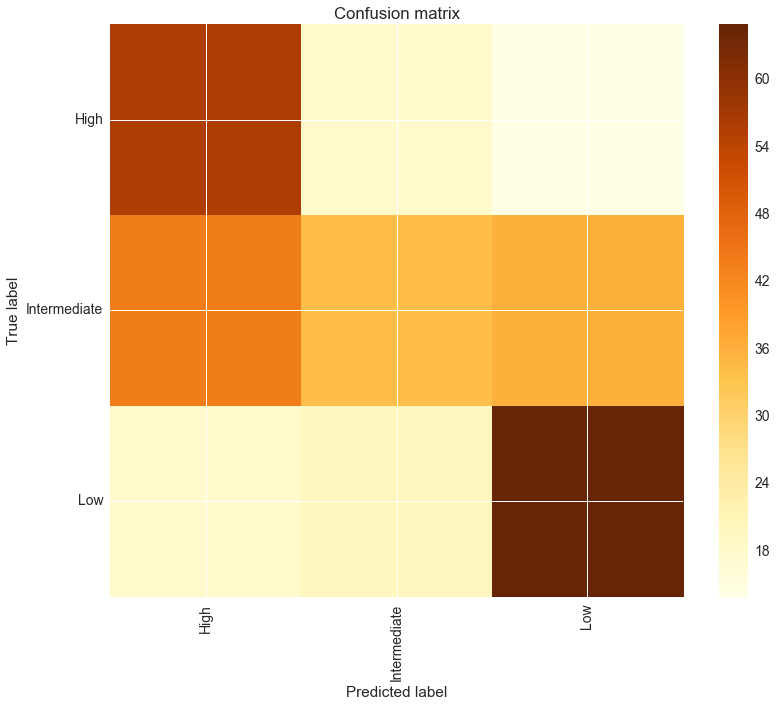

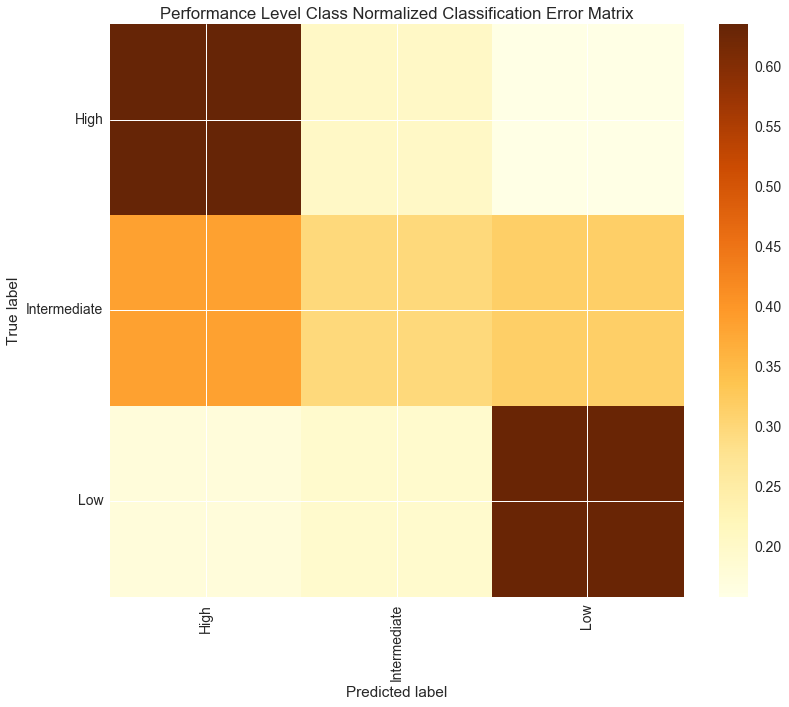

In [182]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(features_perfclass, meta, "usagecategory","YlOrBr", "Performance Level Class")

# Inclass differences

In [183]:
features_office = features_perfclass[features_perfclass.index.str.contains("Office")]
meta_office = meta[meta.index.str.contains("Office")]

In [184]:
features_primsec = features_perfclass[features_perfclass.index.str.contains("PrimClass")]
meta_primsec = meta[meta.index.str.contains("PrimClass")]

Model accuracy: 0.690476190476
Model accuracy: 0.460317460317
             precision    recall  f1-score   support

       High       0.43      0.56      0.49        16
Intermediate       0.57      0.60      0.59        20
        Low       0.90      0.70      0.79        27

avg / total       0.68      0.63      0.65        63

Feature ranking:
1. feature BG_stats_n2d (0.041220)
2. feature BG_stlreminder_feb_mean (0.025303)
3. feature BG_jmotiftemporal_168_8_21_max (0.022243)
4. feature BG_breakouts_max_30_1_5 (0.022162)
5. feature BG_breakouts_max_10_2_5 (0.020855)
6. feature BG_stltrend_aug_mean (0.018042)
7. feature BG_stlreminder_sep_mean (0.016910)
8. feature BG_weekdays_meanvs95_mean (0.016420)
9. feature BG_loadshape_rmse_interval_daytime (0.016314)
10. feature BG_dayfilterfreq_5_6h_mean (0.016159)
11. feature BG_weekdays_minvsmax_mean (0.015742)
12. feature BG_breakouts_max_10_1_5 (0.014910)
13. feature BG_loadshape_rmse_interval (0.014550)
14. feature BG_dayfilterfreq_9_8h_me

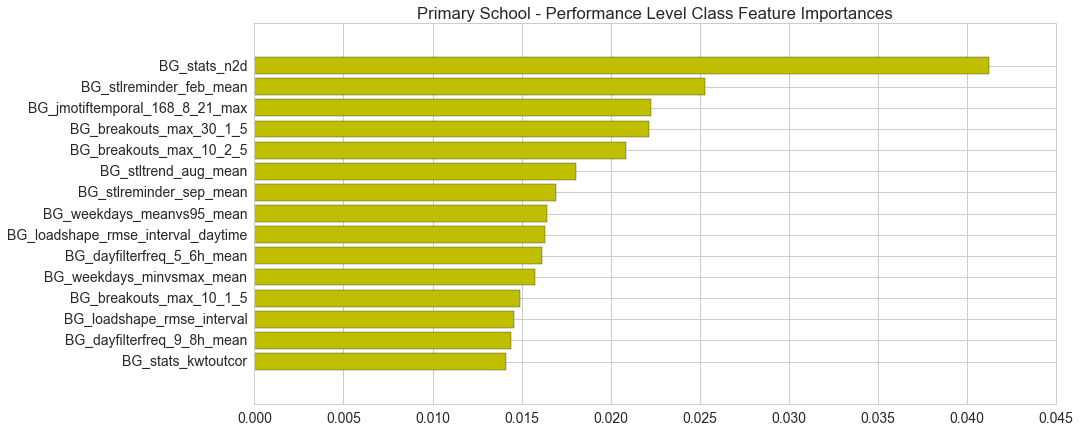

Confusion matrix, without normalization
[[ 9  5  2]
 [ 8 12  0]
 [ 4  4 19]]
Normalized confusion matrix
[[ 0.56  0.31  0.12]
 [ 0.4   0.6   0.  ]
 [ 0.15  0.15  0.7 ]]


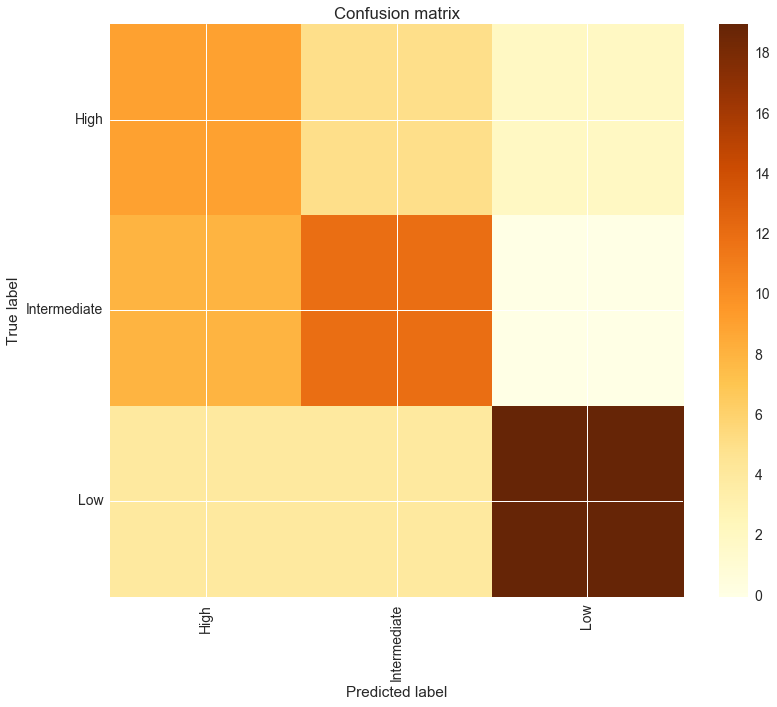

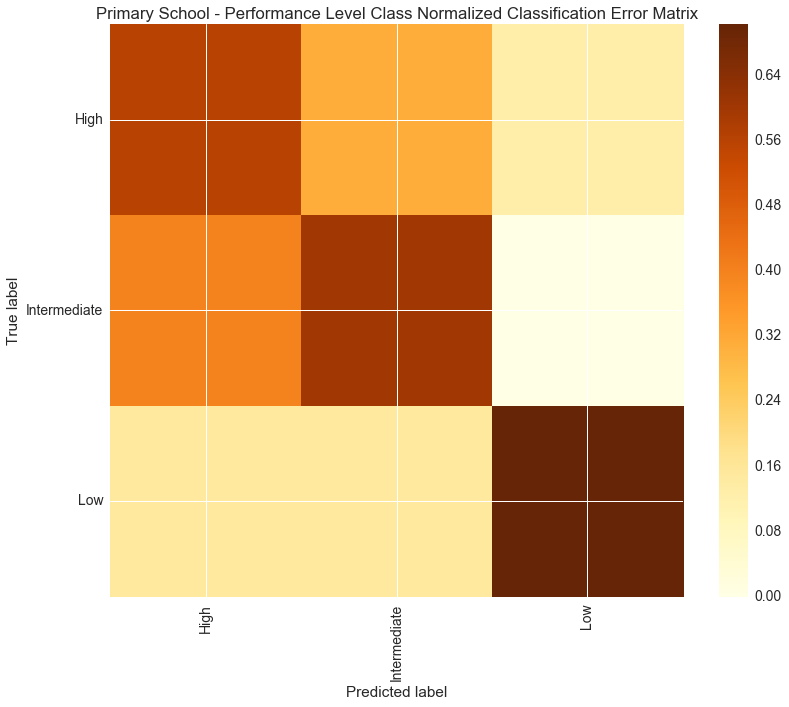

In [185]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(features_primsec, meta_primsec, "usagecategory", "YlOrBr", "Primary School - Performance Level Class")

Model accuracy: 0.645161290323
Model accuracy: 0.329787234043
             precision    recall  f1-score   support

       High       0.55      0.52      0.53        31
Intermediate       0.37      0.19      0.25        36
        Low       0.39      0.67      0.49        27

avg / total       0.44      0.44      0.42        94

Feature ranking:
1. feature BG_weekend_meanvsmax_std (0.029190)
2. feature BG_all_meanvsmax_mean (0.021383)
3. feature BG_weekdays_minvsmax_mean (0.020820)
4. feature BG_seasonal_Jan_mn2mx (0.018084)
5. feature BG_weekdays_minvs95_min (0.017737)
6. feature BG_all_minvsmax_min (0.017228)
7. feature BG_all_meanvs95_mean (0.017183)
8. feature BG_weekdays_meanvs95_min (0.016827)
9. feature BG_weekend_meanvs95_min (0.016143)
10. feature BG_weekend_meanvsmax_min (0.015851)
11. feature BG_weekdays_meanvsmax_max (0.015518)
12. feature BG_eemeter_cvrmse (0.013206)
13. feature BG_weekdays_meanvsmax_mean (0.012836)
14. feature BG_weekend_meanvs95_mean (0.012555)
15. featu

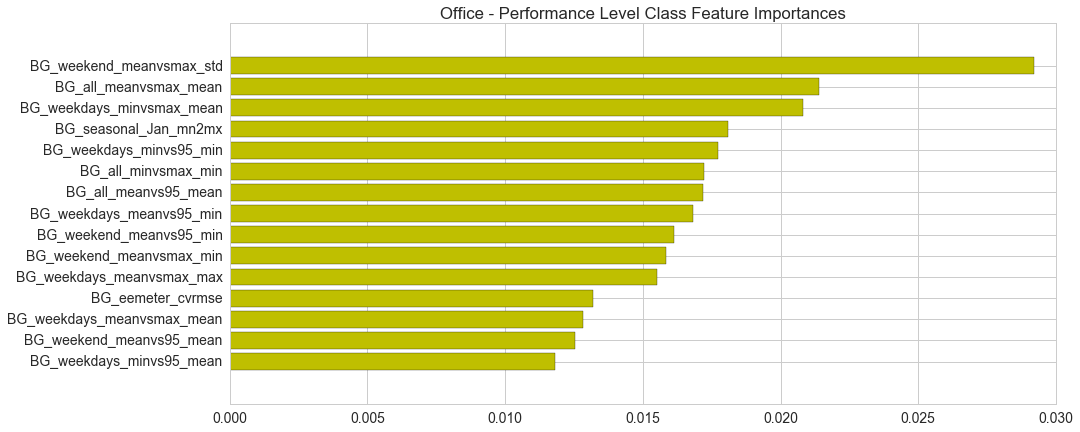

Confusion matrix, without normalization
[[16  8  7]
 [ 8  7 21]
 [ 5  4 18]]
Normalized confusion matrix
[[ 0.52  0.26  0.23]
 [ 0.22  0.19  0.58]
 [ 0.19  0.15  0.67]]


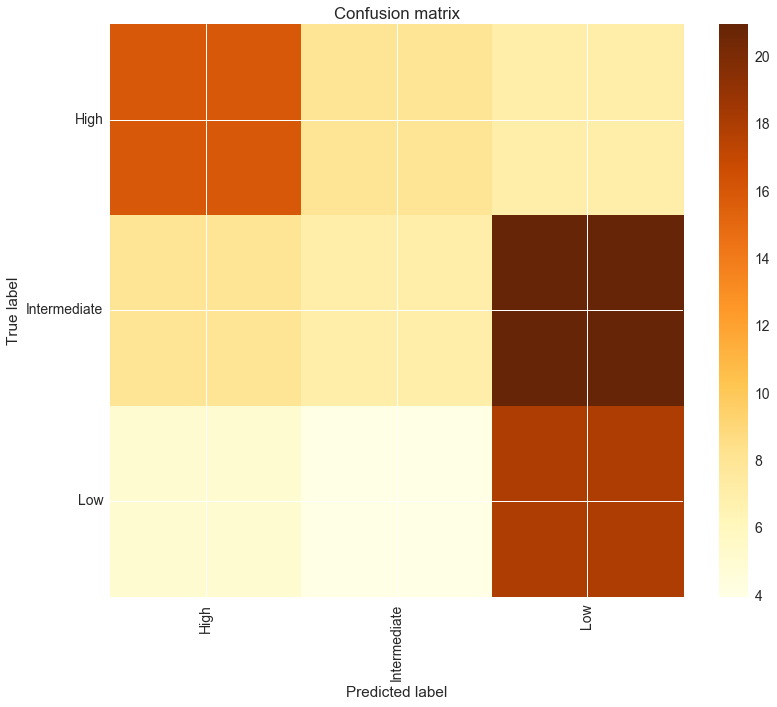

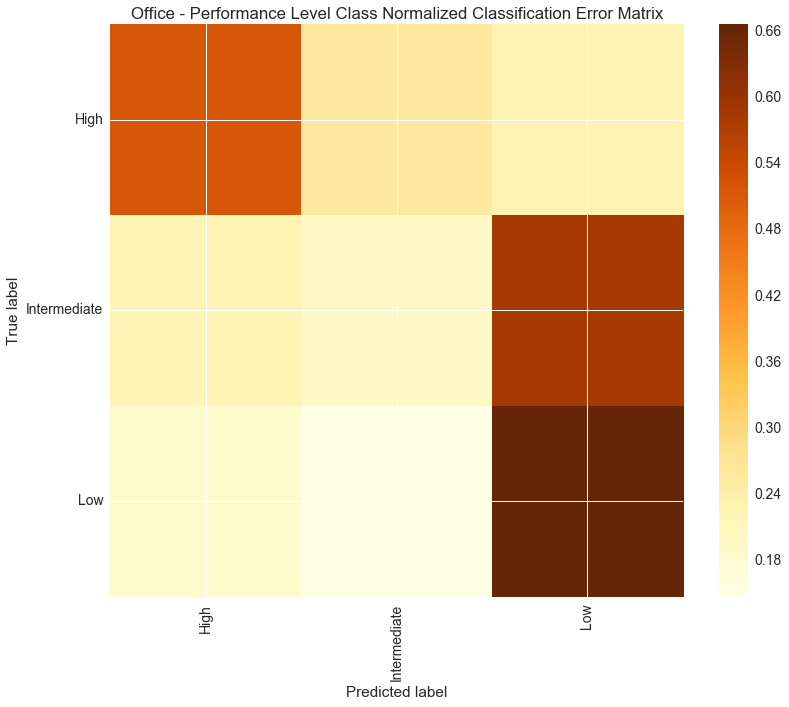

In [186]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(features_office, meta_office, "usagecategory", "YlOrBr", "Office - Performance Level Class")

# Group operations-based

In [187]:
def get_group(x):
    if "_A" in x:
        return "Group1"
    elif "_J" in x:
        return "Group2"
    elif "_C" in x:
        return "Group3"
    elif "_M" in x:
        return "Group4"
    elif "_P" in x:
        return "Group5"
    elif "_L" in x:
        return "Group6"
    elif "_S" in x:
        return "Group7"
#     elif "_B" in x:
#         return "Group8"
#     elif "_D" in x:
#         return "Group8"
#     elif "_N" in x:
#         return "Group9"
#     elif "_T" in x:
#         return "Group10"
#     elif "_U" in x:
#         return "Group11"
    else:
        return "Misc"

In [188]:
meta["operationsgroup"] = meta.apply(lambda x: get_group(x.name), axis=1)

In [189]:
features_operationsgroup = features[feature_names[feature_names.operationtype_applicable == 'operationtype'].index]

In [190]:
meta_operations = meta[meta.operationsgroup != 'Misc']

Model accuracy: 0.80487804878
Model accuracy: 0.16935483871
             precision    recall  f1-score   support

     Group1       1.00      1.00      1.00        66
     Group2       0.98      1.00      0.99        56
     Group3       0.72      0.96      0.82        49
     Group4       0.93      0.86      0.89        29
     Group5       0.71      0.24      0.36        21
     Group6       0.79      0.73      0.76        15
     Group7       0.67      0.67      0.67        12

avg / total       0.88      0.88      0.87       248

Feature ranking:
1. feature BG_dayfilterfreq_5_6h_min (0.040956)
2. feature BG_consumpstats_maxdaydate (0.035638)
3. feature BG_stats_mindaydate (0.034517)
4. feature BG_all_minvs95_max (0.029238)
5. feature BG_stats_minhrkw (0.028557)
6. feature BG_dayfilterfreq_3_6h_min (0.025876)
7. feature BG_dayfilterfreq_9_6h_min (0.024481)
8. feature BG_loadshape_mape_interval_daytime (0.024091)
9. feature BG_dayfilterfreq_7_6h_min (0.020874)
10. feature BG_consumps

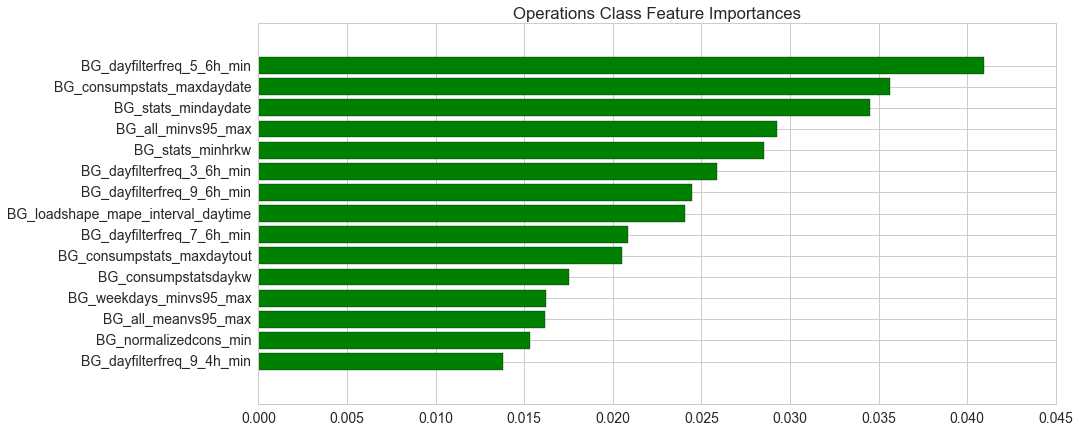

Confusion matrix, without normalization
[[66  0  0  0  0  0  0]
 [ 0 56  0  0  0  0  0]
 [ 0  0 47  0  2  0  0]
 [ 0  0  4 25  0  0  0]
 [ 0  0 14  2  5  0  0]
 [ 0  0  0  0  0 11  4]
 [ 0  1  0  0  0  3  8]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.96  0.    0.04  0.    0.  ]
 [ 0.    0.    0.14  0.86  0.    0.    0.  ]
 [ 0.    0.    0.67  0.1   0.24  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.73  0.27]
 [ 0.    0.08  0.    0.    0.    0.25  0.67]]


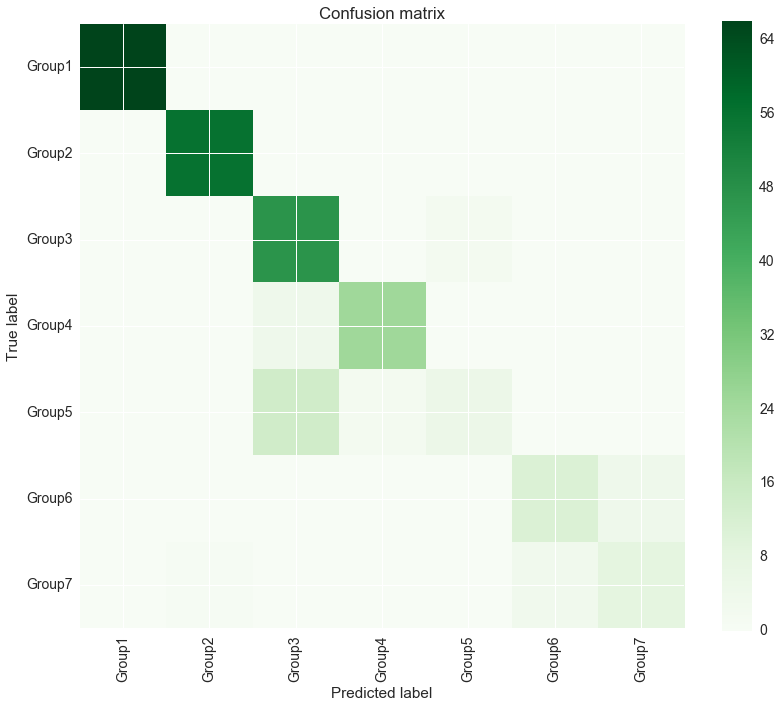

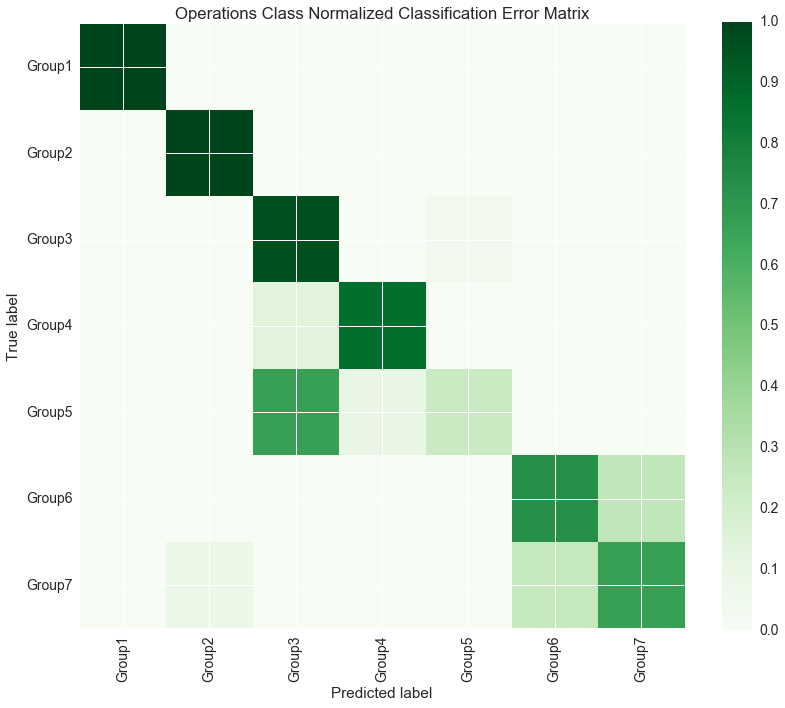

In [191]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(features_operationsgroup, meta_operations, "operationsgroup", "Greens", "Operations Class")

In [192]:
meta.to_csv(os.path.join(repos_path,"data/raw/meta_open_withclassificationobjectives.csv"))